In [10]:
%matplotlib inline

In [11]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from torchvision.models import resnet18

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [13]:
augs = T.Compose([
    T.RandomRotation(degrees = 15),
    # T.Resize((40,40)),
    # T.RandomResizedCrop((32,32), scale = (0.6,1), ratio=(1,1)),
    T.ColorJitter(brightness=0.2, contrast = 0.2, hue = 0.2, saturation=0.2),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_augs=  T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

Load the Cifar10 dataset

In [14]:
batch_size_train = 64
batch_size_test = 64

train_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = True,
                                          download=True,
                                          transform=augs)
test_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = False,
                                          download=True,
                                          transform=test_augs)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, shuffle = True)
print(train_loader)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

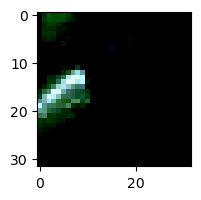

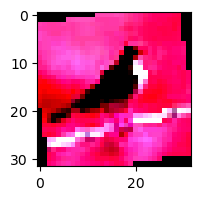

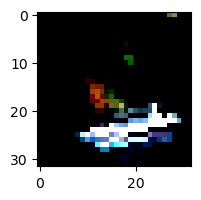

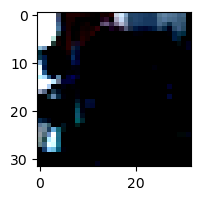

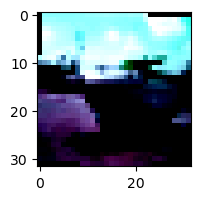

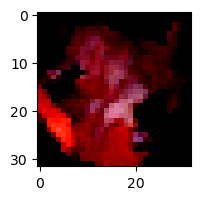

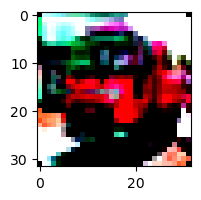

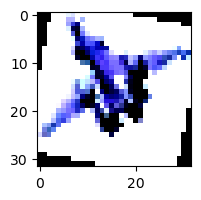

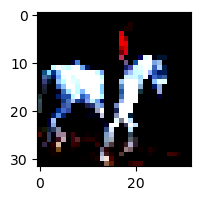

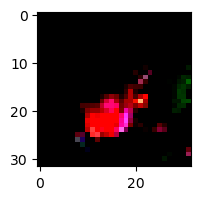

In [15]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    imshow(torchvision.utils.make_grid(images[i]))

Create the model

In [16]:
model = resnet18(pretrained = True)
# for params in model.parameters():
#     params.requires_grad = False

model.fc = nn.Sequential(

    nn.Linear(512, 10),
    nn.Softmax(-1)
)

model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Initialize hyperparamters

In [17]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 200

Train the model

In [18]:
train_acc_list = []
test_acc_list = []

train_loss_list = []
test_loss_list = []

es_count = 0 # Patience for LR scheduler
curr_epoch = 0
curr_loss = 0
best_test_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 15:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            test_acc += accuracy.item()

        test_acc /= len(test_loader)
        test_loss /= len(test_loader)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        if test_acc > best_test_acc:
            best_epoch = epoch
            best_test_acc = test_acc
            torch.save(model.state_dict(), "best_resnet.pth")

    scheduler.step(test_loss)

    if abs(test_loss - curr_loss) < 0.005 or test_loss > curr_loss:
        es_count += 1
        curr_loss = test_loss
    else:
        es_count = 0
        curr_loss = test_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {test_acc:.4f}")


Epoch 1/200 - Training Acc: 0.5004 - Validation Acc: 0.5943
Epoch 2/200 - Training Acc: 0.5818 - Validation Acc: 0.6347
Epoch 3/200 - Training Acc: 0.5989 - Validation Acc: 0.6537
Epoch 4/200 - Training Acc: 0.6113 - Validation Acc: 0.6506
Epoch 5/200 - Training Acc: 0.6206 - Validation Acc: 0.6557
Epoch 6/200 - Training Acc: 0.6291 - Validation Acc: 0.6929
Epoch 7/200 - Training Acc: 0.6423 - Validation Acc: 0.6932
Epoch 8/200 - Training Acc: 0.6481 - Validation Acc: 0.6989
Epoch 9/200 - Training Acc: 0.6544 - Validation Acc: 0.7053
Epoch 10/200 - Training Acc: 0.6620 - Validation Acc: 0.7084
Epoch 11/200 - Training Acc: 0.6611 - Validation Acc: 0.7027
Epoch 12/200 - Training Acc: 0.6718 - Validation Acc: 0.7308
Epoch 13/200 - Training Acc: 0.6785 - Validation Acc: 0.7185
Epoch 14/200 - Training Acc: 0.6803 - Validation Acc: 0.7162
Epoch 15/200 - Training Acc: 0.6822 - Validation Acc: 0.7266
Epoch 16/200 - Training Acc: 0.6903 - Validation Acc: 0.7243
Epoch 00017: reducing learning ra

In [19]:

train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
train_acc_list = np.array(train_acc_list)
test_acc_list = np.array(test_acc_list)

writer = SummaryWriter()
writer.flush()
for i in range(curr_epoch):
    writer.add_scalars('Loss', {'Train': train_loss_list[i], 'Test': test_loss_list[i]}, i)
    writer.add_scalars('Accuracy', {'Train': train_acc_list[i], 'Test': test_acc_list[i]}, i)

writer.close()

Evaluate test accuracy

In [21]:
best_model = model()
best_model.load_state_dict(torch.load("best_resnet.pth"))
best_model.to(device)